<a href="https://colab.research.google.com/github/ywang1110/Modeling_Triboelectric_Performance/blob/main/Humidity___SEBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from sklearn.feature_selection import f_regression

# Prepare dataset

## Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_excel('drive/My Drive/1 Manuscript_AFM/Data process/3 NewData_Train - updateDiameter-Validiate.xlsx', sheet_name='mean')
df.head()

,Unnamed: 0,ChargeDensity(µC/m2) j,Thickness (um) x,solidity y,diameter (um) z,Interface (mm) u,Tem (°C),Humidity (%),Force (N),Technique
0,K-1,26.43,472.4,0.164,9.09225,1.728,26.4,25.9,35.5,Reicofil
1,K-2,28.35,568.1,0.180,9.30286,1.961,25.7,27.5,37.1,Reicofil
2,K-3,31.15,472.9,0.181,7.73240,1.501,26.9,28.5,36.1,Reicofil
3,K-4,30.28,600.2,0.179,7.77859,1.990,25.8,29.6,37.3,Reicofil
4,K-5,33.76,393.3,0.206,7.41502,1.106,26.9,28.5,36.1,Reicofil


In [7]:
df.shape

(43, 10)

## Unit conversion

In [8]:
data = pd.DataFrame()
data['ChargeDensity(C/m2)']=df['ChargeDensity(µC/m2) j']*pow(10,-6)
data['thickness(m)']=df['Thickness (um) x']*pow(10,-6)
data['solidity'] = df['solidity y']
data['diameter(m)'] = df['diameter (um) z']*pow(10,-6)
data['Interface(m)']=df['Interface  (mm) u']*pow(10, -3)
data['Technique'] = df['Technique']
data[['Tem (°C)', 'Humidity (%)', 'Force (N)']]=df[['Tem (°C)', 'Humidity (%)', 'Force (N)']]

data.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1


In [9]:
data.shape

(43, 9)

# Train test split

In [10]:
random_state=69
kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
train_indexs = []
test_indexs = []
for train_index, test_index in kf.split(data):
    train_indexs.append(train_index)
    test_indexs.append(test_index)
index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
index

,train_index,test_index
0,"[0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, ...","[1, 4, 8, 13, 23, 29, 37, 39, 40]"
1,"[1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, ...","[0, 5, 6, 10, 17, 18, 19, 27, 31]"
2,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16...","[2, 14, 15, 25, 28, 30, 35, 36, 38]"
3,"[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 1...","[3, 7, 12, 16, 21, 24, 34, 42]"
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 20, 22, 26, 32, 33, 41]"


In [11]:
n_fold=2

In [12]:
train_index = index.iloc[n_fold,0]
test_index = index.iloc[n_fold,1]
train, test = data.iloc[train_index], data.iloc[test_index]
train.shape

(34, 9)

In [13]:
train.shape

(34, 9)

In [14]:
test.shape

(9, 9)

In [15]:
"""
train.to_csv('train.csv')
test.to_csv('test.csv')
"""


"\ntrain.to_csv('train.csv')\ntest.to_csv('test.csv')\n"

In [16]:
"""
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
"""

"\ntrain = pd.read_csv('train.csv')\ntest=pd.read_csv('test.csv')\n"

In [17]:
train.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1


In [18]:
# Train the model
x=train['thickness(m)'].to_numpy()
y=train['solidity'].to_numpy()
z=train['diameter(m)'].to_numpy()
u=train['Interface(m)'].to_numpy()
h=train['Humidity (%)'].to_numpy()
j=train['ChargeDensity(C/m2)'].to_numpy()
def func(X,a, w, c, m, n, p):
  x,y,z,u,h = X
  return (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

# lm
popt_lm,pcov = curve_fit(func,(x,y,z,u,h),j, method='lm', maxfev = 50000)
y_model_lm = func((x,y,z,u, h),popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4],popt_lm[5]) 
MSE_lm = mean_squared_error(j, y_model_lm)
MAE_lm = mean_absolute_error(j, y_model_lm)
lm_result="lm Method | MSE = {:.2E}| MAE = {:.2E}| a = {:.2E}, w = {:.2E}, c = {:.2E},m = {:.2E}, n = {:.2E}, p = {:.2E}".format(MSE_lm,MAE_lm,popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4],popt_lm[5])
lm_result  

'lm Method | MSE = 1.96E-12| MAE = 1.13E-06| a = 5.87E-06, w = 6.53E-08, c = 2.31E-01,m = 1.28E+00, n = 1.44E+00, p = 1.47E+00'

In [19]:
# initial guesses for a,b,c,m,n,p:
p0 = 1E-6 , 0 ,1. , 1. , 1., 1.

In [20]:
  # trf & dogbox
       #    a          w           c        m          n       p
  bound=((  0,         0,          0,       0,         0 ,     0 ), 
       (np.inf,    np.inf,    np.inf,     np.inf,    np.inf, np.inf))
  
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='trf', maxfev=50000)

  y_model_trf = func((x,y,z,u,h),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4],popt_trf[5]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='dogbox', maxfev=50000)
  y_model_dog = func((x,y,z,u,h),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4],popt_dog[5]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
    a,w,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5]
    print('trf Method is the best method')
  else:
    a,w,c,m,n,p = popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5]
    print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5])
  print(trf_result)
  print(dog_result)

trf Method is the best method
trf Method | MSE = 1.96E-12| MAE = 1.13E-06| a = 5.874322373286812e-06, w = 6.534235949232691e-08, c = 0.23141858659366696,m = 1.2810318155346905, n = 1.4369036386191405, p = 1.4686712848195835
dog Method | MSE = 3.11E-11| MAE = 4.51E-06| a = 3.0150341873134238e-06, w = 0.0, c = 1.057881457452267,m = 1.0000074483021628, n = 1.0000090607620764, p = 1.0000097592583057


In [21]:
  # Validate (when trf is best)

  data_val = pd.concat([train, test])
  data_val.head()
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h=data_val['Humidity (%)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()

  


  data_val['Predicted(C/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  data_val['ratio(%)'] = (data_val['Predicted(C/m2)'] -data_val['ChargeDensity(C/m2)'])/data_val['ChargeDensity(C/m2)']*100
  data_val['ChargeDensity(uC/m2)'] = data_val['ChargeDensity(C/m2)']*pow(10,6)
  data_val['Predicted(uC/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)*pow(10,6)
  data_val['ratio_2(%)'] = (data_val['Predicted(uC/m2)']-data_val['ChargeDensity(uC/m2)'])/data_val['ChargeDensity(uC/m2)']*100
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
  mape = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])
  
  print('MAPE= {:.2f}'.format(mape))
  print('Train_MAPE = {:.2f}'.format(mape_train))
  print('test_MAPE = {:.2f}'.format(mape_test))

MAPE= 4.46
Train_MAPE = 4.21
test_MAPE = 5.38


In [22]:
data_val.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5,0.000026,-0.101657,26.43,26.403132,-0.101657
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1,0.000028,-0.208301,28.35,28.290947,-0.208301
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000028,-7.761488,30.28,27.929822,-7.761488
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000031,-9.351349,33.76,30.602985,-9.351349
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000033,-5.317701,34.67,32.826353,-5.317701


In [23]:
data_val.to_csv('data_val_SEBS.csv')

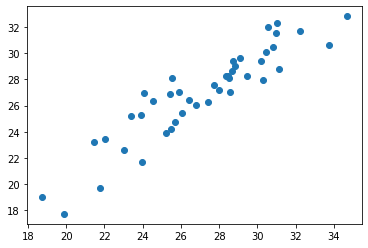

In [24]:
import matplotlib.pyplot as plt
plt.scatter(data_val['ChargeDensity(uC/m2)'], data_val['Predicted(uC/m2)'])
plt.show()

# simulation

In [25]:
avg_thickness = data['thickness(m)'].mean()
avg_solidity = data['solidity'].mean()
avg_diameter = data['diameter(m)'].mean()
avg_u = data['Interface(m)'].mean()


print('avg_thickness = {:.2f}\navg_solidity = {:.3f}\navg_diameter = {:.2f} '.format(avg_thickness, avg_solidity, avg_diameter))
print('avg_u = {:.3f}'.format(avg_u))
print('thickness | {:.2f}-{:.2f} um'.format(data['thickness(m)'].min()*1E6, data['thickness(m)'].max()*1E6))
print('solidity | {:.2f}-{:.2f}'.format(data['solidity'].min(), data['solidity'].max()))
print('diameter | {:.2f}-{:.2f} um'.format(data['diameter(m)'].min()*1E6, data['diameter(m)'].max()*1E6))

avg_thickness = 0.00
avg_solidity = 0.194
avg_diameter = 0.00 
avg_u = 0.002
thickness | 354.60-623.10 um
solidity | 0.15-0.24
diameter | 6.73-16.99 um


In [26]:
data.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1


In [27]:
set_thickness = data.loc[0]['thickness(m)']
set_solidity = data.loc[0]['solidity']
set_diameter = data.loc[0]['diameter(m)']
set_u = data.loc[0]['Interface(m)']
set_h = data.loc[0]['Humidity (%)']
print('set_thickness = {:.3E}\nset_solidity = {:.3f}\nset_diameter = {:.2E} \nset_u= {:.3f} \nset_h= {:.1f}'.format(set_thickness, set_solidity, set_diameter, set_u, set_h))

set_j = data.loc[0]['ChargeDensity(C/m2)']
print('measured j= {:.2E}'.format(set_j))

set_thickness = 4.724E-04
set_solidity = 0.164
set_diameter = 9.09E-06 
set_u= 0.002 
set_h= 25.9
measured j= 2.64E-05


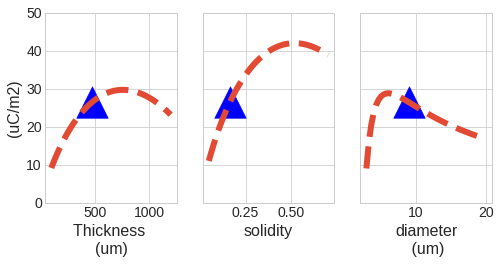

In [28]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.facecolor'] = 'none'


fig, ax = plt.subplots(1,3, figsize=(8,3.5), sharey=True)


#-----------------------------------------------------------------------------------------------
# Thickness ~ charge
x = np.linspace(100, 1200)*pow(10,-6)
y = set_solidity
z = set_diameter
u = set_u
h = set_h

J =  (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[0].plot(x*pow(10,6), J*pow(10,6), linestyle="--", linewidth = 6)
ax[0].scatter(set_thickness*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[0].set_xlabel("Thickness \n(um)", fontsize=16)
ax[0].set_ylabel("(uC/m2)", fontsize=16)
ax[0].tick_params(axis = 'x', labelsize=14)
ax[0].tick_params(axis = 'y', labelsize=14)
ax[0].set_ylim(0,50)



#-----------------------------------------------------------------------------------------------
# solidity ~ charge

x = set_thickness
y = np.linspace(0.05, 0.7)
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)


ax[1].plot(y,J*pow(10,6), linestyle="--", linewidth = 6)
ax[1].scatter(set_solidity, set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[1].set_xlabel("solidity", fontsize=16)

ax[1].tick_params(axis = 'x', labelsize=14)
ax[1].tick_params(axis = 'y', labelsize=14)

    
#-----------------------------------------------------------------------------------------------
# Diameter ~ Charge

x = set_thickness
y = set_solidity
z = np.linspace(3, 20)*pow(10,-6)
u = set_u
h = set_h

J =  (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[2].plot(z*pow(10,6),J*pow(10,6), linestyle="--", linewidth = 6)
ax[2].scatter(set_diameter*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[2].set_xlabel("diameter\n (um)", fontsize=16)




ax[2].tick_params(axis = 'x', labelsize=14)
ax[2].tick_params(axis = 'y', labelsize=14)

In [29]:
simulation_df = pd.DataFrame()

#-----------------------------------------------------------------------------------------------
# Thickness ~ charge
x = np.linspace(100, 1200)*pow(10,-6)
y = set_solidity
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)


simulation_df['thickness (um)']=np.linspace(100, 1200)
simulation_df['charge (uC)_1']=J*pow(10,6)

#-----------------------------------------------------------------------------------------------
# solidity ~ charge

x = set_thickness
y = np.linspace(0.05, 0.7)
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)




simulation_df['solidity']=y
simulation_df['charge (uC)_2']=J*pow(10,6)

    
#-----------------------------------------------------------------------------------------------
# Diameter ~ Charge

x = set_thickness
y = set_solidity
z = np.linspace(3, 20)*pow(10,-6)
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)



simulation_df['diameter (um)']=z*pow(10,6)
simulation_df['charge (uC)_3']=J*pow(10,6)

In [30]:
simulation_df.head()

,thickness (um),charge (uC)_1,solidity,charge (uC)_2,diameter (um),charge (uC)_3
0,100.000000,9.172126,0.050000,11.023243,3.000000,9.047524
1,122.448980,10.813000,0.063265,13.298710,3.346939,15.957414
2,144.897959,12.349417,0.076531,15.412898,3.693878,20.562255
3,167.346939,13.790889,0.089796,17.386641,4.040816,23.655719
4,189.795918,15.144853,0.103061,19.235296,4.387755,25.728794


In [31]:
simulation_df.to_excel('simulation_df_SEBS.xlsx')

# Validation at different random seeds

In [32]:
def get_index(random_state, data):
  kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
  train_indexs = []
  test_indexs = []
  for train_index, test_index in kf.split(data):
      train_indexs.append(train_index)
      test_indexs.append(test_index)
  index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
  return index

In [33]:
def get_scores(n_fold, index, data):
  train_index = index.iloc[n_fold,0]
  test_index = index.iloc[n_fold,1]
  train, test = data.iloc[train_index], data.iloc[test_index]
  train_shape=train.shape
  test_shape=test.shape

  def func(X,a, w, c, m, n, p):
    x,y,z,u,h = X
    return (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  x=train['thickness(m)'].to_numpy()
  y=train['solidity'].to_numpy()
  z=train['diameter(m)'].to_numpy()
  u=train['Interface(m)'].to_numpy()
  h=train['Humidity (%)'].to_numpy()
  j=train['ChargeDensity(C/m2)'].to_numpy()


  # initial guesses for a,b,c,m,n,p:
  p0 = 1E-6 , 1E-10 ,1. , 1. , 1., 1.

   # trf & dogbox
       #    a          w           c        m          n       p
  bound=((  0,         0,          0,       0,         0 ,     0 ), 
       (np.inf,    np.inf,    np.inf,     np.inf,    np.inf, np.inf))
  
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='trf', maxfev=500000)

  y_model_trf = func((x,y,z,u,h),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4],popt_trf[5]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='dogbox', maxfev=500000)
  y_model_dog = func((x,y,z,u,h),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4],popt_dog[5]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
    a,w,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5]
    print('trf Method is the best method')
  else:
    a,w,c,m,n,p = popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5]
    print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5])
  # print(trf_result)
  # print(dog_result)
  
  # Validate 
  
  data_val = pd.concat([train, test])
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h=data_val['Humidity (%)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()


  data_val['Predicted(C/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
  mape_trf = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_trf_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_trf_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])

  return n_fold, train_shape, test_shape, mape_trf, mape_trf_train, mape_trf_test

In [49]:
max_random_sate = 200

In [50]:
random_states = []
n_folds = []
train_shapes = []
test_shapes = []

MAPEs = []
train_MAPEs = []
test_MAPEs = []


for random_state in range(max_random_sate):
  index = get_index(random_state, data)
  for n_fold in range(1):
    random_states.append(random_state)
    n_fold, train_shape, test_shape, MAPE, train_MAPE, test_MAPE = get_scores(n_fold, index, data)
    n_folds.append(n_fold)
    train_shapes.append(train_shape)
    test_shapes.append(test_shape)
    
    MAPEs.append(MAPE)
    train_MAPEs.append(train_MAPE)
    test_MAPEs.append(test_MAPE)


trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method

In [51]:
summary = pd.DataFrame()
summary['random_state']=random_states
summary['n_fold']=n_folds
summary['train_shape'] = train_shapes
summary['test_shape'] = test_shapes

summary['MAPE'] = MAPEs
summary['train_MAPE'] = train_MAPEs
summary['test_MAPE'] = test_MAPEs

summary

,random_state,n_fold,train_shape,test_shape,MAPE,train_MAPE,test_MAPE
0,0,0,"(34, 9)","(9, 9)",4.374903,4.212144,4.989767
1,1,0,"(34, 9)","(9, 9)",4.488931,4.166879,5.705569
2,2,0,"(34, 9)","(9, 9)",4.465304,4.098958,5.849275
3,3,0,"(34, 9)","(9, 9)",4.363335,3.893665,6.137644
4,4,0,"(34, 9)","(9, 9)",4.472362,4.392419,4.774368
...,...,...,...,...,...,...,...
195,195,0,"(34, 9)","(9, 9)",4.385099,4.379483,4.406315
196,196,0,"(34, 9)","(9, 9)",4.265381,4.349379,3.948055
197,197,0,"(34, 9)","(9, 9)",4.372717,4.783045,2.822589
198,198,0,"(34, 9)","(9, 9)",4.406299,3.938490,6.173575


In [52]:
summary.describe()

,random_state,n_fold,MAPE,train_MAPE,test_MAPE
count,200.000000,200.0,200.000000,200.000000,200.000000
mean,99.500000,0.0,4.390390,4.175024,5.203993
std,57.879185,0.0,0.094880,0.300203,1.219999
min,0.000000,0.0,4.213397,3.152417,2.625292
25%,49.750000,0.0,4.316530,4.000269,4.321376
50%,99.500000,0.0,4.379749,4.207587,5.170605
75%,149.250000,0.0,4.454978,4.394524,6.036230
max,199.000000,0.0,4.733977,4.783045,9.056812


In [53]:
summary.to_csv('100RandomState_SEBS.csv')

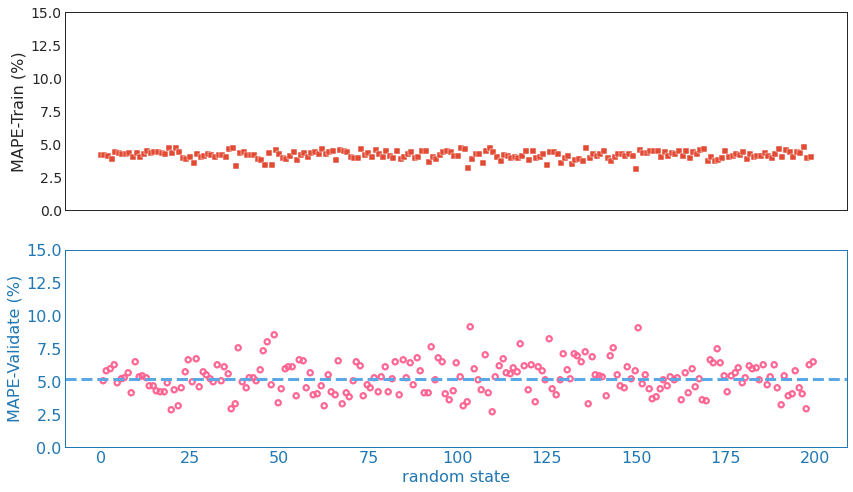

In [90]:
sns.set_style("white")
plt.rcParams['axes.facecolor'] = 'none'


fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
sns.scatterplot(ax=ax[0], data=summary, x="random_state", y="train_MAPE", marker = 's')
ax[0].set_xlabel("random state", fontsize=16)
ax[0].set_ylabel("MAPE-Train (%)", fontsize=16)
ax[0].tick_params(axis = 'x', labelsize=14)
ax[0].tick_params(axis = 'y', labelsize=14)
ax[0].set_ylim(0,15)


sns.scatterplot(ax=ax[1], data=summary, x="random_state", y="test_MAPE", marker="$\circ$", s=100, color = '#ff6392', ec="face")


ax[1].set_xlabel("random state", fontsize=16)
ax[1].set_ylabel("MAPE-Validate (%)", fontsize=16)
ax[1].tick_params(axis = 'x', labelsize=16)
ax[1].tick_params(axis = 'y', labelsize=16)
ax[1].xaxis.label.set_color('tab:blue')
ax[1].yaxis.label.set_color('tab:blue')
ax[1].set_ylim(0,15)
l2=ax[1].axhline(5.20, color='#5AA9E6', ls='dashed', linewidth=3)
ax[1].tick_params(axis='x', colors='tab:blue')
ax[1].tick_params(axis='y', colors='tab:blue')

ax[1].spines['bottom'].set_color('tab:blue')
ax[1].spines['top'].set_color('tab:blue')
ax[1].spines['right'].set_color('tab:blue')
ax[1].spines['left'].set_color('tab:blue')